In [2]:
import numpy as np
import astropy
from astropy.io import ascii
from astropy.table import Table
import scipy.linalg as la 
import pandas as pd     
import requests
import uncertainties
import matplotlib.pyplot as plt
import astropy.constants as const
import astropy.units as u
import json
import os
from scipy.optimize import curve_fit
import time

In [2]:
header = ["Exclusion Code",
            "D",
            "G",
            "Galaxy ID",
            "m-M",
            "err",
            "D (Mpc)",
            "Method",
            "REFCODE",
            "SN ID",
            "redshift (z)",
            "Hubble const.",
            "Adopted LMC modulus",
            "Date (Yr. - 1980)", 
            "Notes"]
ned_data = pd.read_csv("./NED30.5.1-D-17.1.2-20200415.csv", names=header, skiprows=13)

In [3]:
np.unique(ned_data['Method'])

array(['AGB', 'AGN time lag', 'B Stars', 'BCG', 'BL Lac Luminosity',
       'Black Hole', 'Blue Supergiant', 'Brightest Stars', 'CMD',
       'CO ring diameter', 'Carbon Stars', 'Cepheids', 'D-Sigma',
       'Delta Scuti', 'Diameter', 'Dwarf Ellipticals',
       'Dwarf Galaxy Diameter', 'Eclipsing Binary', 'FGLR', 'FP',
       'Faber-Jackson', 'G Lens', 'GC FP', 'GC K vs. (J-K)', 'GC SBF',
       'GC radius', 'GCLF', 'GRB', 'GeV TeV ratio',
       'Grav. Stability Gas. Disk', 'Grav. Wave',
       'H I + optical distribution', 'HII LF', 'HII region diameter',
       'Horizontal Branch', 'IRAS', 'Jet Proper Motion',
       'L(H{beta})-{sigma}', 'LSB galaxies', 'M Stars', 'Magnitude',
       'Maser', 'Mass Model', 'Miras', 'Novae', 'OB Stars',
       'Orbital Mech.', 'PAGB Stars', 'PNLF', 'Proper Motion',
       'Quasar spectrum', 'RR Lyrae', 'RSV Stars', 'RV Stars',
       'Radio Brightness', 'Red Clump', 'Ring Diameter',
       'S Doradus Stars', 'SBF', 'SGRB', 'SNII optical', 'SNII rad

In [107]:
def getGalInfo(galname):
    # res_headers = {
    #     'Content-type': 'application/json',
    # }
    res_data = {
        'json': '{"name":{"v": "%s"}}' % galname
    }
    res = requests.post('https://ned.ipac.caltech.edu/srs/ObjectLookup', data=res_data)
    return res.json()

## Pick three methods to calculate the H_0 and then compare them for uncertainty analysis

Calculation method
$$v_r = cz$$
$$v_r = H_0 D$$
$$H_0 = \frac{cz}{D}$$

In [5]:
bh_lum_mass_relation = ned_data[ned_data["Method"] == "Black Hole"]

In [6]:
trgb_method = ned_data[ned_data["Method"] == "TRGB"]

In [7]:
if not os.path.exists('./bh_lm_reshift.json'):
    bh_host_info = {}
    for index, row in bh_lum_mass_relation.iterrows():
        try:
            gal_info = getGalInfo(row["Galaxy ID"])["Preferred"]
        except:
            print(row["Galaxy ID"], "no data")
            continue
        redshift = gal_info["Redshift"]["Value"] 
        z_err = gal_info["Redshift"]["Uncertainty"]
        paper_reference = gal_info["Redshift"]["RefCode"]
        if redshift is None:
            print(row["Galaxy ID"], " redshift is null")
            continue
        bh_host_info[row["Galaxy ID"]] = (redshift, z_err, paper_reference)
        time.sleep(1)
    with open("bh_lm_reshift.json", "w") as fout:
        json.dump(bh_host_info, fout)
else:
    with open("./bh_lm_reshift.json", "r") as fread:
        bh_host_info = json.load(fread)

In [8]:
if not os.path.exists('./trgb_reshift.json'):
    trgb_host_info = {}
    for index, row in trgb_method.iterrows():
        try:
            gal_info = getGalInfo(row["Galaxy ID"])["Preferred"]
        except:
            print(row["Galaxy ID"], "no data")
            continue
        redshift = gal_info["Redshift"]["Value"] 
        z_err = gal_info["Redshift"]["Uncertainty"]
        paper_reference = gal_info["Redshift"]["RefCode"]
        if redshift is None:
            print(row["Galaxy ID"], " redshift is null")
            continue
        trgb_host_info[row["Galaxy ID"]] = (redshift, z_err, paper_reference)
        time.sleep(1)
    with open("trgb_reshift.json", "w") as fout:
        json.dump(trgb_host_info, fout)
else:
    with open("./trgb_reshift.json", "r") as fread:
        trgb_host_info = json.load(fread)

not plot omega Cen


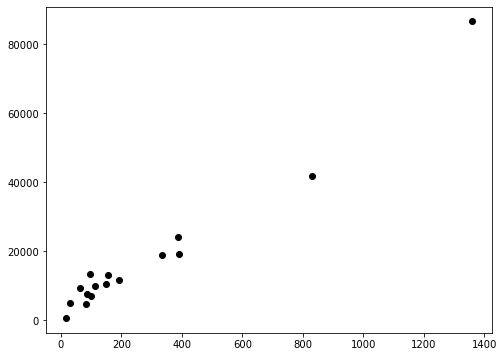

In [19]:
plt.figure(figsize=(8, 6))
bh_lm_vr = []
bh_lm_d = []
bh_lm_err_vr = []
for index, row in bh_lum_mass_relation.iterrows():
    # print(bh_host_info[row["Galaxy ID"]][0])
    if row["Galaxy ID"] not in bh_host_info.keys():
        print("not plot %s" % row["Galaxy ID"])
        continue
    plt.scatter(row["D (Mpc)"], const.c.to(u.km/u.s) * bh_host_info[row["Galaxy ID"]][0], c="k")
    bh_lm_d.append(row["D (Mpc)"])
    bh_lm_vr.append(const.c.to(u.km/u.s) * bh_host_info[row["Galaxy ID"]][0])
    bh_lm_err_vr.append(const.c.to(u.km/u.s) * bh_host_info[row["Galaxy ID"]][1])

Exclusion Code                             NaN
D                                        83292
G                                        17202
Galaxy ID              2MASX J07422426+6525569
m-M                                      27.65
err                                       0.26
D (Mpc)                                   3.39
Method                                    TRGB
REFCODE                    2016ApJ...828L...5C
SN ID                                      NaN
redshift (z)                               NaN
Hubble const.                              NaN
Adopted LMC modulus                        NaN
Date (Yr. - 1980)                         36.0
Notes                                        i
Name: 128133, dtype: object
0.074985 0.0 2014ApJS..210....9B
Exclusion Code                         NaN
D                                    94236
G                                    25985
Galaxy ID                   ESO 165- G 003
m-M                                  28.21
err                

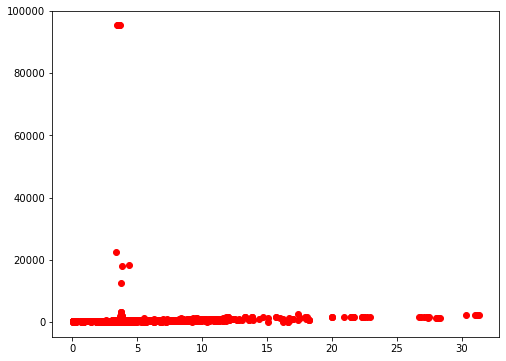

In [82]:
plt.figure(figsize=(8, 6))
trgb_d = []
trgb_vr = []
trgb_err_vr = []
for index, row in trgb_method.iterrows():
    # print(bh_host_info[row["Galaxy ID"]][0])
    # if 3.35 < row["D (Mpc)"] and  row["D (Mpc)"] < 3.8:
    #     continue
    if row["Galaxy ID"] not in trgb_host_info.keys():
        # print("not plot %s" % row["Galaxy ID"])
        continue
    # 3 sigma cut
    if trgb_host_info[row["Galaxy ID"]][0] < 3 * trgb_host_info[row["Galaxy ID"]][1]:
        # print(index, row["Galaxy ID"], "rejected by 3 sigma cut")
        continue
    if row["D (Mpc)"] < 10 and (const.c.to(u.km/u.s) * trgb_host_info[row["Galaxy ID"]][0]).value > 3000:
        print(row)
        print(trgb_host_info[row["Galaxy ID"]][0], trgb_host_info[row["Galaxy ID"]][1], trgb_host_info[row["Galaxy ID"]][2])
    plt.scatter(row["D (Mpc)"], const.c.to(u.km/u.s) * trgb_host_info[row["Galaxy ID"]][0], c="r")
    trgb_d.append(row["D (Mpc)"])
    trgb_vr.append(const.c.to(u.km/u.s) * trgb_host_info[row["Galaxy ID"]][0])
    trgb_err_vr.append(const.c.to(u.km/u.s) * trgb_host_info[row["Galaxy ID"]][1])
# plt.ylim([0, 2e3])

In [11]:
def hubble(d, H0):
    return H0 * d

In [95]:
trgb_vr_data = [i.value for i in trgb_vr]
remove_value = (3.35 < np.array(trgb_d)) & (np.array(trgb_d) < 3.8) 
mask =  ((np.array(trgb_d) < 100)) & (np.array(trgb_d) > 1.5) & ~remove_value
trgb_popt, trgb_pcov = curve_fit(hubble, np.array(trgb_d)[mask], np.array(trgb_vr_data)[mask])
print(trgb_popt, trgb_pcov)

[67.64829846] [[9.7750529]]


<ErrorbarContainer object of 3 artists>

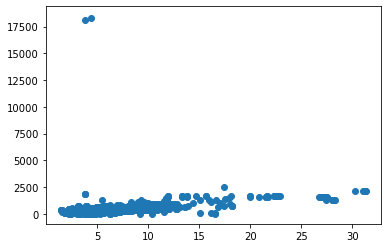

In [96]:
# mask =  ((np.array(trgb_d) < 25))
trgb_err_vr_data = [i.value for i in trgb_err_vr]
# plt.scatter(np.array(trgb_d)[mask], np.array(trgb_vr_data)[mask])
plt.errorbar(np.array(trgb_d)[mask], np.array(trgb_vr_data)[mask], 
            yerr=np.array(trgb_err_vr_data)[mask], fmt='o')
# plt.ylim([0, 200])

In [45]:
bh_lm_vr_data = [i.value for i in bh_lm_vr]
mask = np.ones_like(np.array(bh_lm_d), dtype=bool) #((np.array(bh_lm_vr_data) < 60000))
bh_lm_popt, bh_lm_pcov = curve_fit(hubble, np.array(bh_lm_d)[mask], np.array(bh_lm_vr_data)[mask])
print(bh_lm_popt, bh_lm_pcov)

[60.47032946] [[5.18558083]]


In [101]:
snIa = ned_data[ned_data["Method"] == "SNIa"]
snIa_sdss = snIa[snIa['REFCODE'] == '2018PASP..130f4002S']

In [108]:
if not os.path.exists('./snIa_reshift.json'):
    snIa_host_info = {}
    for index, row in snIa_sdss.iterrows():
        try:
            gal_info = getGalInfo(row["Galaxy ID"])["Preferred"]
        except:
            print(row["Galaxy ID"], "no data")
            continue
        redshift = gal_info["Redshift"]["Value"] 
        z_err = gal_info["Redshift"]["Uncertainty"]
        paper_reference = gal_info["Redshift"]["RefCode"]
        if redshift is None:
            print(row["Galaxy ID"], " redshift is null")
            continue
        snIa_host_info[row["Galaxy ID"]] = (redshift, z_err, paper_reference)
        time.sleep(1)
    with open("snIa_reshift.json", "w") as fout:
        json.dump(bh_host_info, fout)
else:
    with open("./snIa_reshift.json", "r") as fread:
        snIa_host_info = json.load(fread)

SDSS-II SN 06225  redshift is null
SDSS-II SN 06225  redshift is null
SDSS-II SN 06225  redshift is null
SDSS-II SN 06225  redshift is null
SDSS-II SN 15756  redshift is null
SDSS-II SN 15756  redshift is null
SDSS-II SN 16551  redshift is null
SDSS-II SN 16551  redshift is null
SDSS-II SN 16551  redshift is null
SDSS-II SN 16551  redshift is null
SDSS-II SN 04211  redshift is null
SDSS-II SN 04211  redshift is null
SDSS-II SN 04211  redshift is null
SDSS-II SN 04211  redshift is null
SDSS-II SN 03475  redshift is null
SDSS-II SN 03475 no data
SDSS-II SN 03475 no data
SDSS-II SN 03475 no data
SDSS-II SN 15239 no data
SDSS-II SN 15239 no data
SDSS-II SN 15239 no data
SDSS-II SN 15239 no data
SDSS-II SN 15850 HOST no data
SDSS-II SN 15850 HOST no data
SDSS-II SN 15850 no data
SDSS-II SN 15850 no data
2MASX J00024910+0045055 no data
2MASX J00024910+0045055 no data
2MASX J00024910+0045055 no data
SDSS-II SN 00722 no data
SDSS-II SN 04069 no data
SDSS-II SN 04069 no data
SDSS-II SN 14343 no

In [63]:
for paper in np.unique(snIa["REFCODE"]):
    print(len(snIa[snIa["REFCODE"] == paper]), sum(snIa[snIa["REFCODE"] == paper]["redshift (z)"]>= 0.01))

26 0
2 0
2 0
16 0
4 0
4 0
2 0
2 0
96 0
10 0
2 0
3 0
10 0
28 0
2 0
2 0
2 0
6 0
26 0
2 0
4 0
2 0
2 0
26 0
16 0
52 0
14 0
46 0
40 34
2 0
160 156
16 16
20 0
4 4
2 0
8 0
2 0
2 0
10 2
354 0
2 0
2 0
16 0
2 0
2 2
4 0
2 0
2 0
2 2
2 0
2 0
4 0
12 12
70 70
2 0
2 0
116 116
372 370
2 0
42 42
222 0
234 234
6 0
18 18
196 146
180 172
2 0
2 0
2 0
6 0
82 82
262 184
828 828
10 10
40 0
6 0
796 764
88 58
2 0
2 0
12 0
214 0
2 0
6 0
2972 2914
78 52
112 112
4 0
1152 1152
1000 1000
56 54
30 0
4 4
1374 1302
34 16
498 498
52 52
8 0
66 0
2 0
20 0
220 188
1720 0
412 0
944 938
2 0
2 0
6 0
2 0
30 30
150 150
40 0
46 0
56 48
216 0
2 2
3008 0
2 2
158 150
2 0
1166 1158
96 0
16 0
1480 1474
2 0
216 0
20 20
670 670
120 118
2 0
2 0
4 0
2 0
4 0
8 8
62 60
2 0
2 0
332 0
36 0
6 0
6 0
690 0
2 0
2 0
4 0
4 0
8 0
42 0
38 0
8 0
12 0
1694 1692
5590 5590


In [59]:
np.sum(snIa[snIa["REFCODE"] == paper]["redshift (z)"] >= 1)

0

In [58]:
any(snIa[snIa["REFCODE"] == paper]["redshift (z)"] >= 1)

False

In [83]:
snIa[(snIa["D (Mpc)"] > 1.5)]

,Exclusion Code,D,G,Galaxy ID,m-M,err,D (Mpc),Method,REFCODE,SN ID,redshift (z),Hubble const.,Adopted LMC modulus,Date (Yr. - 1980),Notes
15,NaN,14,7,SDSS-II SN 14480,40.19,0.30,1090.0,SNIa,2011ApJ...738..162S,SDSS-II SN 14480,NaN,70.0,NaN,31.0,"SN photometric redshift distance, z photo =0.2..."
16,NaN,15,7,SDSS-II SN 14480,41.20,0.33,1300.0,SNIa,2018PASP..130f4002S,SDSS-II SN 14480,0.330796,70.0,NaN,34.0,SDSS CAND. zSNIa; SALT 2
17,NaN,16,7,SDSS-II SN 14480,41.30,0.32,1370.0,SNIa,2018PASP..130f4002S,SDSS-II SN 14480,0.330796,70.0,NaN,34.0,SDSS CAND. zSNIa; MLCS2K2
18,NaN,17,7,SDSS-II SN 14480,41.07,0.22,1640.0,SNIa,2013ApJ...763...88C,SDSS-II SN 14480,NaN,70.0,NaN,33.0,SALT 2
19,NaN,18,7,SDSS-II SN 14480,41.11,0.22,1670.0,SNIa,2013ApJ...763...88C,SDSS-II SN 14480,NaN,70.0,NaN,33.0,"SALT 2, Malmquist cor."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328284,NaN,999999,147416,SN 2005gx,39.81,0.03,812.0,SNIa,2011ApJS..192....1C,SN 2005gx,0.130000,70.0,NaN,31.0,"SDSS J235932.23+004412.6, SDSS-II SN 05103"
328292,NaN,272981,147423,SDSS-II SN 05209,41.31,0.47,1420.0,SNIa,2018PASP..130f4002S,SDSS-II SN 05209,0.284278,70.0,NaN,34.0,SDSS CAND. zSNIa; SALT 2
328293,NaN,999999,147423,SDSS-II SN 05209,41.31,0.47,1420.0,SNIa,2018PASP..130f4002S,SDSS-II SN 05209,0.284278,70.0,NaN,34.0,"SDSS-II SN 05209, SDSS CAND. zSNIa; SALT 2"
328298,NaN,272986,147428,SDSS-II SN 15730,40.15,0.49,1070.0,SNIa,2011ApJ...738..162S,SDSS-II SN 15730,NaN,70.0,NaN,31.0,"SN photometric redshift distance, z photo =0.2..."


In [84]:
snIa

,Exclusion Code,D,G,Galaxy ID,m-M,err,D (Mpc),Method,REFCODE,SN ID,redshift (z),Hubble const.,Adopted LMC modulus,Date (Yr. - 1980),Notes
15,NaN,14,7,SDSS-II SN 14480,40.19,0.30,1090.0,SNIa,2011ApJ...738..162S,SDSS-II SN 14480,NaN,70.0,NaN,31.0,"SN photometric redshift distance, z photo =0.2..."
16,NaN,15,7,SDSS-II SN 14480,41.20,0.33,1300.0,SNIa,2018PASP..130f4002S,SDSS-II SN 14480,0.330796,70.0,NaN,34.0,SDSS CAND. zSNIa; SALT 2
17,NaN,16,7,SDSS-II SN 14480,41.30,0.32,1370.0,SNIa,2018PASP..130f4002S,SDSS-II SN 14480,0.330796,70.0,NaN,34.0,SDSS CAND. zSNIa; MLCS2K2
18,NaN,17,7,SDSS-II SN 14480,41.07,0.22,1640.0,SNIa,2013ApJ...763...88C,SDSS-II SN 14480,NaN,70.0,NaN,33.0,SALT 2
19,NaN,18,7,SDSS-II SN 14480,41.11,0.22,1670.0,SNIa,2013ApJ...763...88C,SDSS-II SN 14480,NaN,70.0,NaN,33.0,"SALT 2, Malmquist cor."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328284,NaN,999999,147416,SN 2005gx,39.81,0.03,812.0,SNIa,2011ApJS..192....1C,SN 2005gx,0.130000,70.0,NaN,31.0,"SDSS J235932.23+004412.6, SDSS-II SN 05103"
328292,NaN,272981,147423,SDSS-II SN 05209,41.31,0.47,1420.0,SNIa,2018PASP..130f4002S,SDSS-II SN 05209,0.284278,70.0,NaN,34.0,SDSS CAND. zSNIa; SALT 2
328293,NaN,999999,147423,SDSS-II SN 05209,41.31,0.47,1420.0,SNIa,2018PASP..130f4002S,SDSS-II SN 05209,0.284278,70.0,NaN,34.0,"SDSS-II SN 05209, SDSS CAND. zSNIa; SALT 2"
328298,NaN,272986,147428,SDSS-II SN 15730,40.15,0.49,1070.0,SNIa,2011ApJ...738..162S,SDSS-II SN 15730,NaN,70.0,NaN,31.0,"SN photometric redshift distance, z photo =0.2..."


In [106]:
snIa_host_info

{'SDSS-II SN 14480': (0.330796, 0.000115, '2018PASP..130f4002S'),
 'SDSS-II SN 19787': (0.1973, 0.001, '2012ApJ...755...61S'),
 'SDSS J000129.96+001633.5': (0.386701, 6.5e-05, '2013ApJ...763...88C'),
 'SDSS-II SN 15239': (0.334228, 2.8e-05, '2018PASP..130f4002S'),
 'SDSS-II SN 15850 HOST': (0.250921, 4.1e-05, '2013ApJ...763...88C'),
 'SDSS-II SN 15850': (0.25, 0.01, '2012ApJ...755...61S'),
 '2MASX J00024910+0045055': (0.086753964,
  3.3657696e-05,
  '2016SDSSD.C...0000:'),
 'SDSS-II SN 04069': (0.086753964, 3.3657696e-05, '2016SDSSD.C...0000:'),
 'SDSS-II SN 14343': (0.307, 0.0, '2011ApJ...738..162S'),
 'SDSS-II SN 15370': (0.51970893, 0.00027071012, '2016SDSSD.C...0000:'),
 'SDSS J000254.37+005623.0': (0.36156, 5.4e-05, '2018PASP..130f4002S'),
 'SDSS-II SN 11858': (0.291263, 1.4e-05, '2018PASP..130f4002S'),
 'SDSS J000502.85+010847.0': (0.18131562,
  2.4395766e-05,
  '2016SDSSD.C...0000:'),
 'SDSS-II SN 04019': (0.1814, 0.0002, '2012ApJ...755...61S'),
 'SDSS J000557.98+010611.1': (0.1